## <center> `Spam SMS Detection using Word Embeddings` </center>

`Dataset:`
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

`Objective:`
Build an AI model that can classify SMS messages as spam or legitimate. Use techniques like TF-IDF or word embeddings with classifiers like Naive Bayes, Logistic Regression, or Support Vector Machines to identify spam messages


<a class="anchor" id="0.1"></a>
# **Table of Contents** 

1.	[Data Preparation](#1)
1.	[Exploratory Data Analysis](#2)
1.	[Feature Engineering with Word Embeddings](#3)
1.	[Train Test Spliting](#3)
1.  [Model Building - UnBalanced Class](#4)
    * [Naive Bayes & Hyperparameter Tuning](#5)
    * [Logistic Regression & Hyperparameter Tuning](#6)
    * [Support Vector Machine & Hyperparameter Tuning](#7)
1.	[Balancing Data](#8)
1.  [Model Building - Balanced Class](#9)
    * [Naive Bayes & Hyperparameter Tuning](#10)
    * [Logistic Regression & Hyperparameter Tuning](#11)
    * [Support Vector Machine & Hyperparameter Tuning](#12)
1.  [Evaluation](#13)
1.	[Deployment](#14)
1.	[Interpretation & Conclusion](#15)
1.	[Reference](#16)


## Data Preparation
<a class="anchor" id="1"></a>
[Table of Contents](#0.1)

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import joblib
import warnings #ignore warning
warnings.filterwarnings("ignore")

In [2]:
# Define file path
filepath ="D://Portfolio//Internship//AFAME//Project details//Spam SMS Detection//spam.csv"
# Read the CSV file into a DataFrame with specified encoding
data = pd.read_csv(filepath, encoding='latin1')
# Display the first few rows of the DataFrame
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# removing excess unnecessary column 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
# Checking null values
data.isnull().sum()

v1    0
v2    0
dtype: int64

In [6]:
# Checking duplicated values
data.duplicated().sum()

403

We are retaining the duplicate values as they are crucial for our task of identifying spam SMS messages.

In [7]:
# Viewing values in 'v1' column
data['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

In [8]:
data.groupby('v1').count()['v2']/data.shape[0]

v1
ham     0.865937
spam    0.134063
Name: v2, dtype: float64

In [9]:
# Viewing unique values in 'v2'
data['v2'].nunique()

5169

## Exploratory Data Analysis
<a class="anchor" id="2"></a>
[Table of Contents](#0.1)

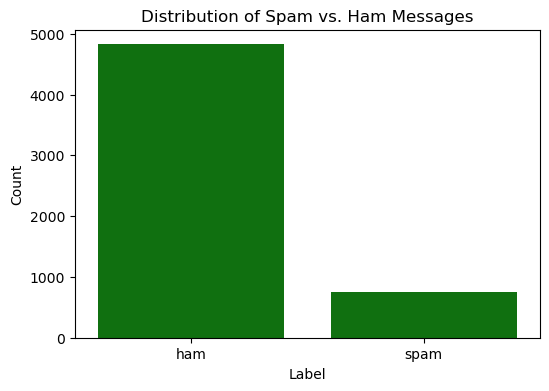

In [10]:
# Distribution of spam vs. ham messages
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='v1', color='green')
plt.title('Distribution of Spam vs. Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

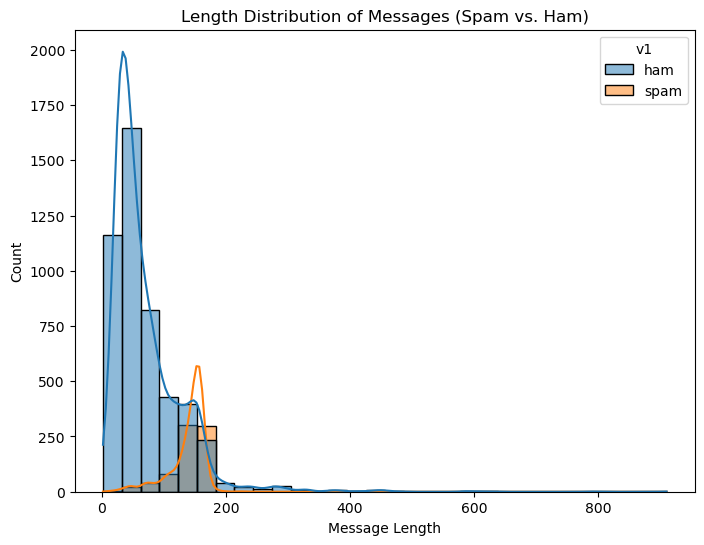

In [11]:
# Distribution of message lengths
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x=data['v2'].apply(len), bins=30, hue='v1', kde=True)
plt.title('Length Distribution of Messages (Spam vs. Ham)')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

## 3.Feature Engineering with Word Embeddings

<a class="anchor" id="3"></a>
[Table of Contents](#0.3)

In [12]:
# Preprocess data
import re
from nltk.tokenize import word_tokenize

def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize the text
    return tokens

data['v2'] = data['v2'].apply(preprocess)


In [13]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=data['v2'], vector_size=100, window=5, min_count=1, workers=4)


In [14]:
def text_to_vector(tokens, model):
    # Get vectors for each token in the text
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    # Return the average vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X = np.array([text_to_vector(tokens, word2vec_model) for tokens in data['v2']])

In [15]:
# Convert labels to integers (0 for ham, 1 for spam)
y = data['v1'].map({'ham': 0, 'spam': 1})
data.head()

,v1,v2
0,ham,"[go, until, jurong, point, crazy, available, o..."
1,ham,"[ok, lar, joking, wif, u, oni]"
2,spam,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,ham,"[u, dun, say, so, early, hor, u, c, already, t..."
4,ham,"[nah, i, dont, think, he, goes, to, usf, he, l..."


## Training/Test Split
<a class="anchor" id="4"></a>
[Table of Contents](#0.1)

In [16]:
# Train-test split
from sklearn.model_selection import train_test_split
# Setting random_state
random_seed = 42
# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Further split the training data into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=random_seed)

# Print the shapes of each set
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (3899, 100) (3899,)
Validation set: (558, 100) (558,)
Testing set: (1115, 100) (1115,)


## Model Building - UnBalanced Class
<a class="anchor" id="5"></a>
[Table of Contents](#0.1)

### Naive Bayes & Hyperparameter Tuning
<a class="anchor" id="6"></a>
[Table of Contents](#0.1)

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79       487
           1       0.27      0.83      0.41        71

    accuracy                           0.70       558
   macro avg       0.62      0.75      0.60       558
weighted avg       0.88      0.70      0.75       558


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.68      0.79       965
           1       0.28      0.81      0.42       150

    accuracy                           0.70      1115
   macro avg       0.62      0.75      0.61      1115
weighted avg       0.87      0.70      0.74      1115



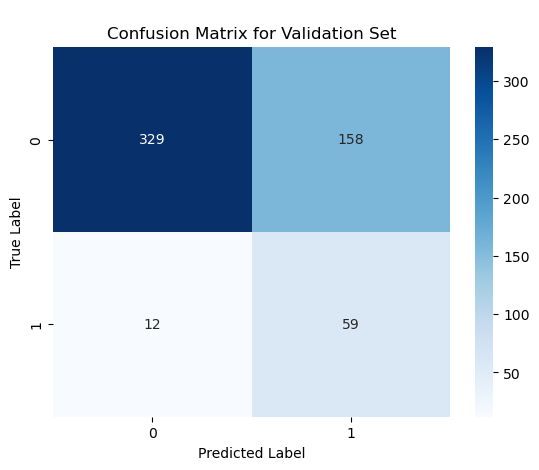

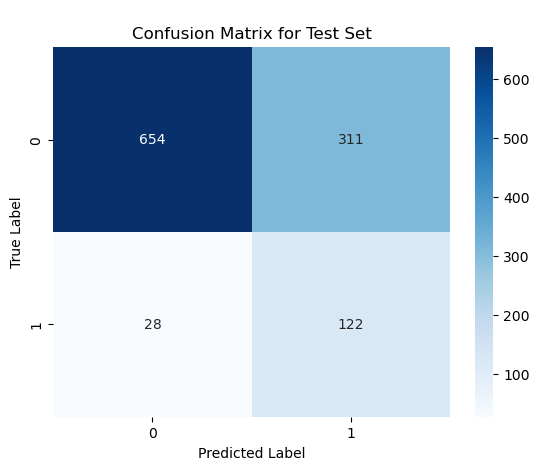

In [17]:
# Importing NaiveBayes from sklearn module
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
# Initialize the model
gnb = GaussianNB()

# Fit the model on the training data
gnb.fit(X_train, y_train)

# Train the model on the training data
gnb.fit(X_train, y_train)

# Predictions on the validation set
gnb_y_val_pred = gnb.predict(X_val)

# Evaluate the model on the validation set
print("Validation Set Evaluation:")
print(classification_report(y_val, gnb_y_val_pred))

# Predictions on the test set
gnb_y_test_pred = gnb.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, gnb_y_test_pred))

# Compute confusion matrix for validation set
gnb_val_cm = confusion_matrix(y_val, gnb_y_val_pred)

# Compute confusion matrix for test set
gnb_test_cm = confusion_matrix(y_test, gnb_y_test_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    #plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix for validation set
plot_confusion_matrix(gnb_val_cm, '\nConfusion Matrix for Validation Set')

# Plot confusion matrix for test set
plot_confusion_matrix(gnb_test_cm, '\nConfusion Matrix for Test Set')

Fitting 5 folds for each of 700 candidates, totalling 3500 fits
Best Hyperparameters for GaussianNB: {'priors': [0.8, 0.2], 'var_smoothing': 1.519911082952933e-06}

Validation Classification Report for GaussianNB (Best Model):
               precision    recall  f1-score   support

           0       0.97      0.67      0.79       487
           1       0.27      0.85      0.41        71

    accuracy                           0.70       558
   macro avg       0.62      0.76      0.60       558
weighted avg       0.88      0.70      0.75       558


Test Classification Report for GaussianNB (Best Model):
               precision    recall  f1-score   support

           0       0.96      0.67      0.79       965
           1       0.28      0.81      0.42       150

    accuracy                           0.69      1115
   macro avg       0.62      0.74      0.60      1115
weighted avg       0.87      0.69      0.74      1115



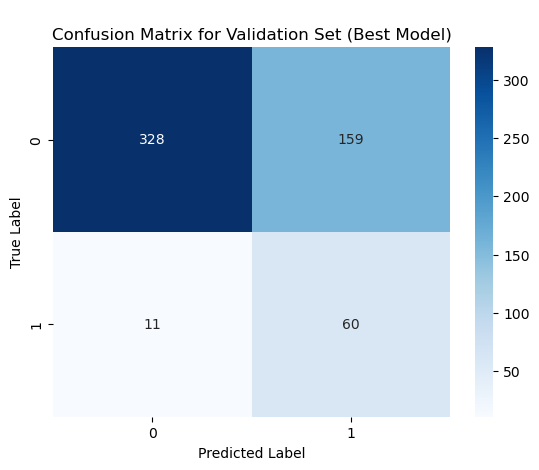

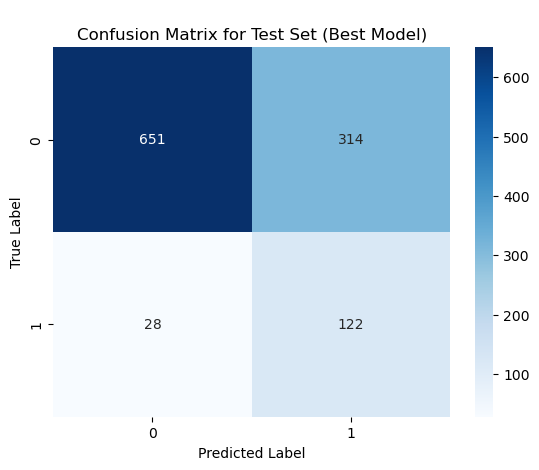

CPU times: total: 6.66 s
Wall time: 16.9 s


In [18]:
%%time
# Importing GridSearchCV for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GaussianNB
var_smoothing_range = np.logspace(0, -9, num=100)
priors_range = [[0.8, 0.2], [0.7, 0.3], [0.6, 0.4], [0.5, 0.5], [0.4, 0.6], [0.3, 0.7], [0.2, 0.8]]
gnb_param_grid = {'var_smoothing': var_smoothing_range, 'priors': priors_range}

# Initialize GridSearchCV for GaussianNB
gnb_grid_search = GridSearchCV(estimator=gnb, param_grid=gnb_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV on training data
gnb_grid_search.fit(X_train, y_train)

# Print the best hyperparameters found for GaussianNB
print("Best Hyperparameters for GaussianNB:", gnb_grid_search.best_params_)

# Get the best GaussianNB model
gnb_best_model = gnb_grid_search.best_estimator_

# Evaluate the best model on validation set for GaussianNB
gnb_y_val_pred = gnb_best_model.predict(X_val)
print("\nValidation Classification Report for GaussianNB (Best Model):\n", classification_report(y_val, gnb_y_val_pred))

# Evaluate the best model on test set for GaussianNB
gnb_y_test_pred = gnb_best_model.predict(X_test)
print("\nTest Classification Report for GaussianNB (Best Model):\n", classification_report(y_test, gnb_y_test_pred))

# Compute confusion matrix for validation set
gnb_val_cm = confusion_matrix(y_val, gnb_y_val_pred)

# Compute confusion matrix for test set
gnb_test_cm = confusion_matrix(y_test, gnb_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(gnb_val_cm,'\nConfusion Matrix for Validation Set (Best Model)')

# Plot confusion matrix for test set
plot_confusion_matrix(gnb_test_cm, '\nConfusion Matrix for Test Set (Best Model)')

### Logistic Regression & Hyperparameter Tuning
<a class="anchor" id="7"></a>
[Table of Contents](#0.1)

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       487
           1       1.00      0.48      0.65        71

    accuracy                           0.93       558
   macro avg       0.96      0.74      0.81       558
weighted avg       0.94      0.93      0.92       558


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       965
           1       0.97      0.43      0.59       150

    accuracy                           0.92      1115
   macro avg       0.94      0.71      0.77      1115
weighted avg       0.92      0.92      0.91      1115



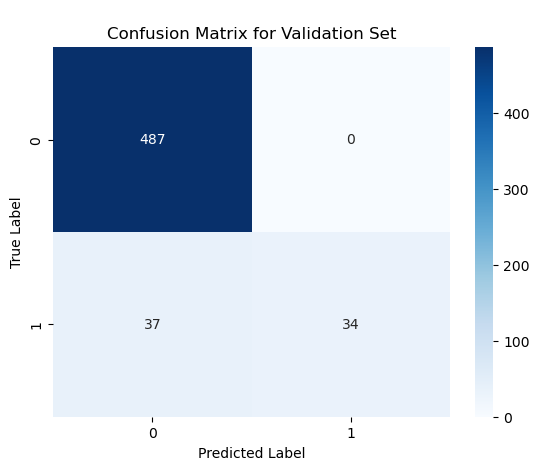

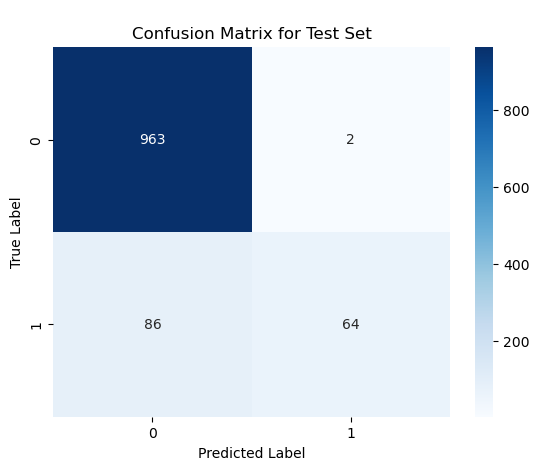

In [19]:
# Import LogisticRegression from sklearn module
from sklearn.linear_model import LogisticRegression

# Initialize the model
lr = LogisticRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Train the model on the training data
lr.fit(X_train, y_train)

# Predictions on the validation set
lr_y_val_pred = lr.predict(X_val)

# Evaluate the model on the validation set
print("Validation Set Evaluation:")
print(classification_report(y_val, lr_y_val_pred))

# Predictions on the test set
lr_y_test_pred = lr.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, lr_y_test_pred))

# Compute confusion matrix for validation set
lr_val_cm = confusion_matrix(y_val, lr_y_val_pred)

# Compute confusion matrix for test set
lr_test_cm = confusion_matrix(y_test, lr_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(lr_val_cm, '\nConfusion Matrix for Validation Set')

# Plot confusion matrix for test set
plot_confusion_matrix(lr_test_cm, '\nConfusion Matrix for Test Set')

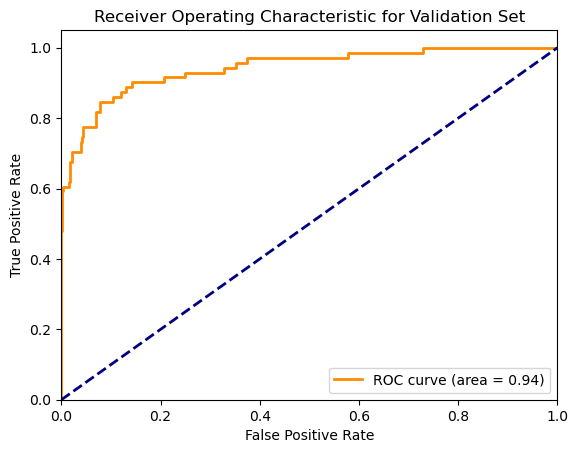

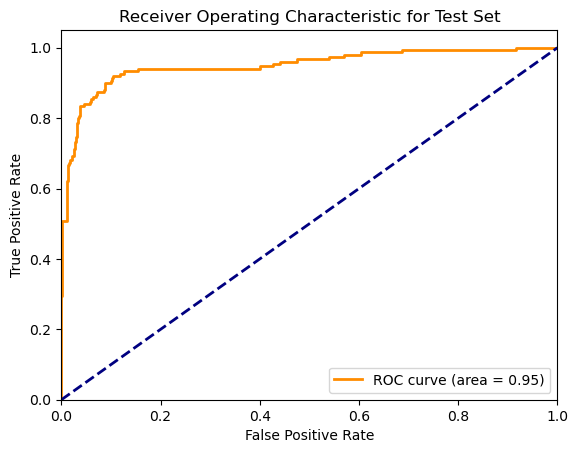

In [20]:
from sklearn.metrics import roc_curve, auc

# Compute the probabilities of the positive class
lr_y_val_prob = lr.predict_proba(X_val)[:, 1]
lr_y_test_prob = lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for validation set
fpr_val, tpr_val, _ = roc_curve(y_val, lr_y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Compute ROC curve and ROC area for test set
fpr_test, tpr_test, _ = roc_curve(y_test, lr_y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for validation set
plt.figure()
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Validation Set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Set')
plt.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'C': 10, 'penalty': 'l2'}

Validation Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       487
           1       0.89      0.70      0.79        71

    accuracy                           0.95       558
   macro avg       0.93      0.85      0.88       558
weighted avg       0.95      0.95      0.95       558


Test Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       965
           1       0.92      0.63      0.75       150

    accuracy                           0.94      1115
   macro avg       0.93      0.81      0.86      1115
weighted avg       0.94      0.94      0.94      1115



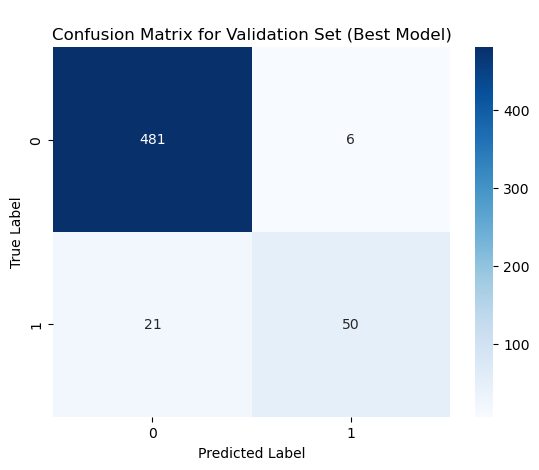

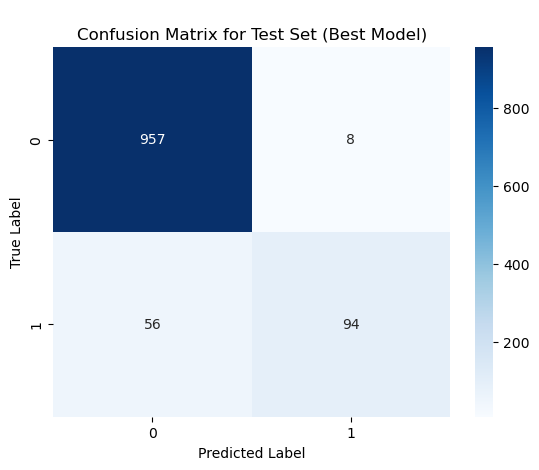

CPU times: total: 484 ms
Wall time: 560 ms


In [21]:
%%time
# Define the parameter grid
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    'penalty': ['l1', 'l2']  # Regularization penalty type
}

# Initialize GridSearchCV
lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=5, scoring='f1', verbose=1)

# Fit GridSearchCV on training data
lr_grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", lr_grid_search.best_params_)

# Get the best model
lr_best_model = lr_grid_search.best_estimator_

# Evaluate the best model on validation set
lr_y_val_pred = lr_best_model.predict(X_val)
print("\nValidation Classification Report (Best Model):\n", classification_report(y_val, lr_y_val_pred))

# Evaluate the best model on test set
lr_y_test_pred = lr_best_model.predict(X_test)
print("\nTest Classification Report (Best Model):\n", classification_report(y_test, lr_y_test_pred))

# Compute confusion matrix for validation set
lr_val_cm = confusion_matrix(y_val, lr_y_val_pred)

# Compute confusion matrix for test set
lr_test_cm = confusion_matrix(y_test, lr_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(lr_val_cm, '\nConfusion Matrix for Validation Set (Best Model)')

# Plot confusion matrix for test set
plot_confusion_matrix(lr_test_cm, '\nConfusion Matrix for Test Set (Best Model)')

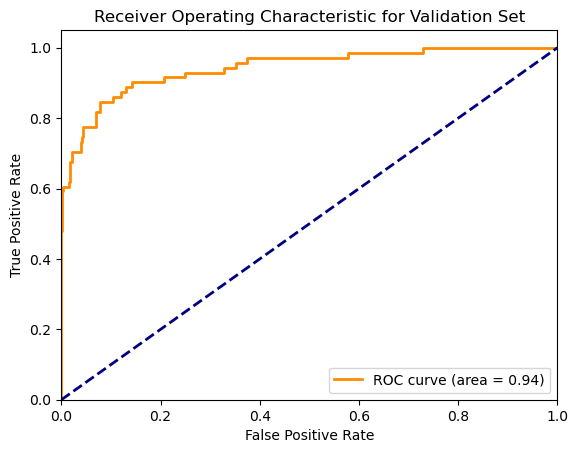

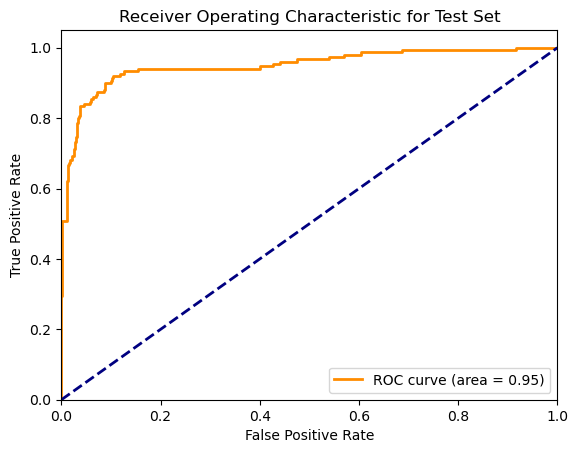

In [22]:
# Compute the probabilities of the positive class
lr_y_val_prob = lr.predict_proba(X_val)[:, 1]
lr_y_test_prob = lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for validation set
fpr_val, tpr_val, _ = roc_curve(y_val, lr_y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Compute ROC curve and ROC area for test set
fpr_test, tpr_test, _ = roc_curve(y_test, lr_y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for validation set
plt.figure()
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Validation Set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Set')
plt.legend(loc="lower right")
plt.show()


### Support Vector Machine & Hyparameter Tuning
<a class="anchor" id="8"></a>
[Table of Contents](#0.1)

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       487
           1       0.96      0.62      0.75        71

    accuracy                           0.95       558
   macro avg       0.95      0.81      0.86       558
weighted avg       0.95      0.95      0.94       558


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       965
           1       0.98      0.53      0.68       150

    accuracy                           0.93      1115
   macro avg       0.95      0.76      0.82      1115
weighted avg       0.94      0.93      0.93      1115



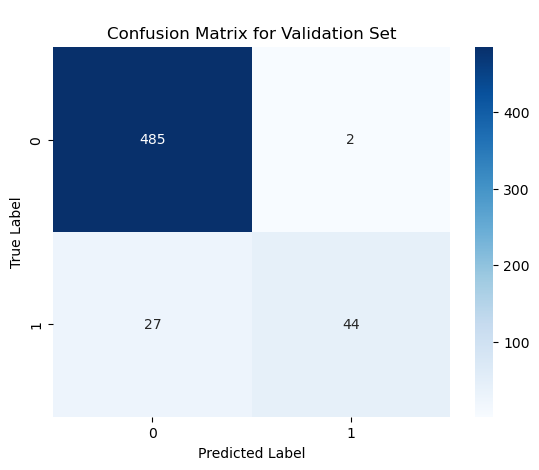

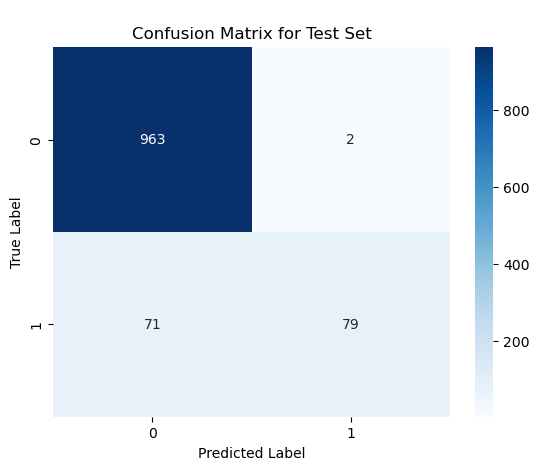

In [23]:
# Import SupportVectorMachine from sklearn module
from sklearn.svm import SVC

# Initialize the model
svc = SVC(kernel='linear')

# Fit the model on the training data
svc.fit(X_train, y_train)

# Train the model on the training data
svc.fit(X_train, y_train)

# Predictions on the validation set
svc_y_val_pred = svc.predict(X_val)

# Evaluate the model on the validation set
print("Validation Set Evaluation:")
print(classification_report(y_val, svc_y_val_pred))

# Predictions on the test set
svc_y_test_pred = svc.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, svc_y_test_pred))

# Compute confusion matrix for validation set
svc_val_cm = confusion_matrix(y_val, svc_y_val_pred)

# Compute confusion matrix for test set
svc_test_cm = confusion_matrix(y_test, svc_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(svc_val_cm, '\nConfusion Matrix for Validation Set')

# Plot confusion matrix for test set
plot_confusion_matrix(svc_test_cm, '\nConfusion Matrix for Test Set')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters for Support Vector Machine: {'C': 10, 'kernel': 'linear'}

Validation Classification Report for Support Vector Machine (Best Model):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       487
           1       0.89      0.69      0.78        71

    accuracy                           0.95       558
   macro avg       0.92      0.84      0.87       558
weighted avg       0.95      0.95      0.95       558


Test Classification Report for Support Vector Machine (Best Model):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       965
           1       0.93      0.67      0.78       150

    accuracy                           0.95      1115
   macro avg       0.94      0.83      0.87      1115
weighted avg       0.95      0.95      0.95      1115



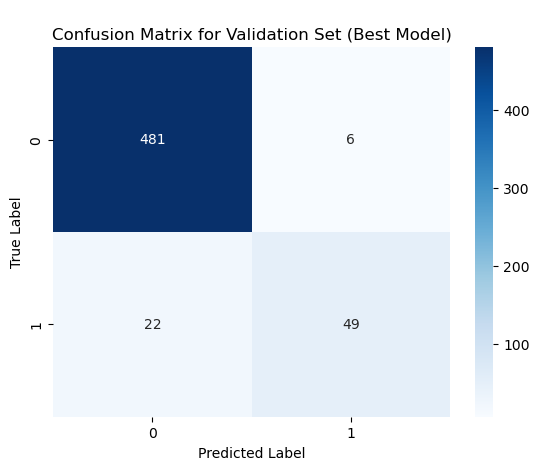

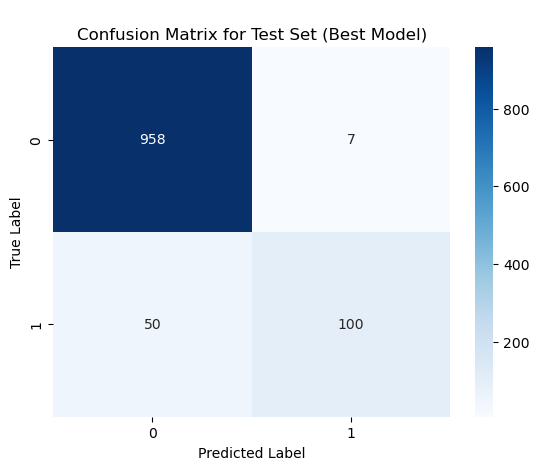

CPU times: total: 8.58 s
Wall time: 8.64 s


In [24]:
%%time
# Define the parameter grid for Support Vector Machine
svc_param_grid = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'kernel': ['linear', 'rbf'] # Kernel type
}


# Initialize GridSearchCV for Support Vector Machine
svc_grid_search = GridSearchCV(estimator=svc, param_grid=svc_param_grid, cv=5, scoring='f1', verbose=1)

# Fit GridSearchCV on training data
svc_grid_search.fit(X_train, y_train)

# Print the best hyperparameters found for Support Vector Machine
print("Best Hyperparameters for Support Vector Machine:", svc_grid_search.best_params_)

# Get the best Support Vector Machine model
svc_best_model = svc_grid_search.best_estimator_

# Evaluate the best model on validation set for Support Vector Machine
svc_y_val_pred = svc_best_model.predict(X_val)
print("\nValidation Classification Report for Support Vector Machine (Best Model):\n", classification_report(y_val, svc_y_val_pred))

# Evaluate the best model on test set for Support Vector Machine
svc_y_test_pred = svc_best_model.predict(X_test)
print("\nTest Classification Report for Support Vector Machine (Best Model):\n", classification_report(y_test, svc_y_test_pred))

# Compute confusion matrix for validation set
svc_val_cm = confusion_matrix(y_val, svc_y_val_pred)

# Compute confusion matrix for test set
svc_test_cm = confusion_matrix(y_test, svc_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(svc_val_cm, '\nConfusion Matrix for Validation Set (Best Model)')

# Plot confusion matrix for test set
plot_confusion_matrix(svc_test_cm, '\nConfusion Matrix for Test Set (Best Model)')

## Balancing Data
<a class="anchor" id="9"></a>
[Table of Contents](#0.1)

In [25]:
# Balancing the data
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
smote = SMOTE(random_state=random_seed)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

## Naive Bayes & Hyperparameter Tuning
<a class="anchor" id="10"></a>
[Table of Contents](#0.1)

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79       487
           1       0.27      0.85      0.41        71

    accuracy                           0.69       558
   macro avg       0.62      0.76      0.60       558
weighted avg       0.88      0.69      0.74       558


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79       965
           1       0.28      0.81      0.41       150

    accuracy                           0.69      1115
   macro avg       0.62      0.74      0.60      1115
weighted avg       0.87      0.69      0.74      1115



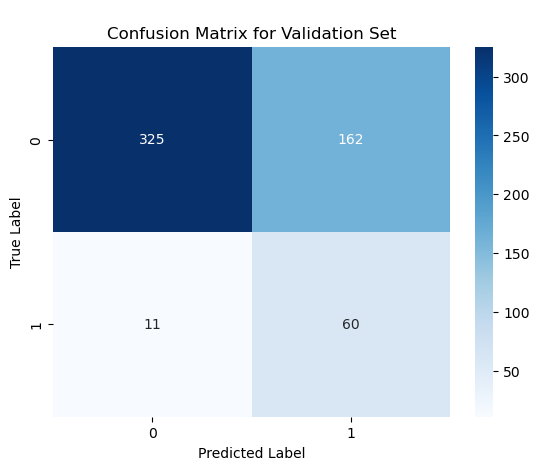

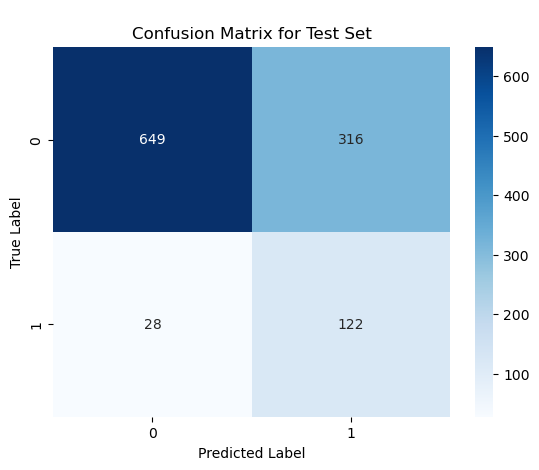

In [26]:
# Train the model on the training data
gnb.fit(X_train_sm, y_train_sm)

# Predictions on the validation set
gnbsm_y_val_pred = gnb.predict(X_val)

# Evaluate the model on the validation set
print("Validation Set Evaluation:")
print(classification_report(y_val, gnbsm_y_val_pred))

# Predictions on the test set
gnbsm_y_test_pred = gnb.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, gnbsm_y_test_pred))

# Compute confusion matrix for validation set
gnbsm_val_cm = confusion_matrix(y_val, gnbsm_y_val_pred)

# Compute confusion matrix for test set
gnbsm_test_cm = confusion_matrix(y_test, gnbsm_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(gnbsm_val_cm, '\nConfusion Matrix for Validation Set')

# Plot confusion matrix for test set
plot_confusion_matrix(gnbsm_test_cm, '\nConfusion Matrix for Test Set')

Fitting 5 folds for each of 700 candidates, totalling 3500 fits
Best Hyperparameters for GaussianNB: {'priors': [0.8, 0.2], 'var_smoothing': 1.232846739442066e-06}

Validation Classification Report for GaussianNB (Best Model):
               precision    recall  f1-score   support

           0       0.97      0.69      0.80       487
           1       0.28      0.83      0.42        71

    accuracy                           0.71       558
   macro avg       0.62      0.76      0.61       558
weighted avg       0.88      0.71      0.75       558


Test Classification Report for GaussianNB (Best Model):
               precision    recall  f1-score   support

           0       0.96      0.68      0.80       965
           1       0.29      0.81      0.42       150

    accuracy                           0.70      1115
   macro avg       0.62      0.75      0.61      1115
weighted avg       0.87      0.70      0.75      1115



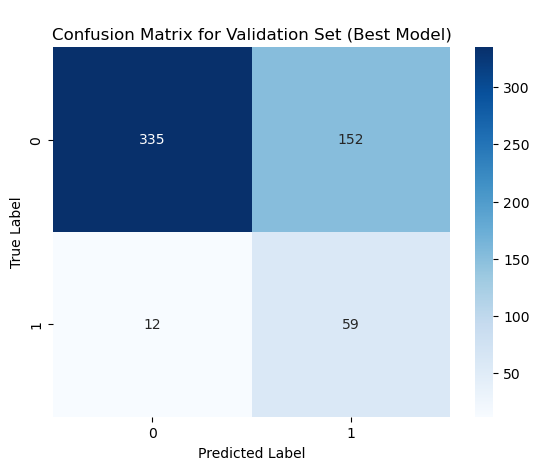

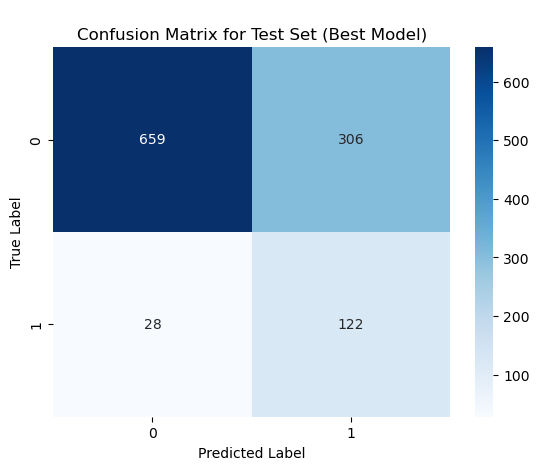

CPU times: total: 43.3 s
Wall time: 43.7 s


In [27]:
%%time
# Initialize GridSearchCV for GaussianNB
gnbsm_grid_search = GridSearchCV(estimator=gnb, param_grid=gnb_param_grid, cv=5, scoring='f1', verbose=1)

# Fit GridSearchCV on training data
gnbsm_grid_search.fit(X_train_sm, y_train_sm)

# Print the best hyperparameters found for GaussianNB
print("Best Hyperparameters for GaussianNB:", gnbsm_grid_search.best_params_)

# Get the best GaussianNB model
gnbsm_best_model = gnbsm_grid_search.best_estimator_

# Evaluate the best model on validation set for GaussianNB
gnbsm_y_val_pred = gnbsm_best_model.predict(X_val)
print("\nValidation Classification Report for GaussianNB (Best Model):\n", classification_report(y_val, gnbsm_y_val_pred))

# Evaluate the best model on test set for GaussianNB
gnbsm_y_test_pred = gnbsm_best_model.predict(X_test)
print("\nTest Classification Report for GaussianNB (Best Model):\n", classification_report(y_test, gnbsm_y_test_pred))

# Compute confusion matrix for validation set
gnbsm_val_cm = confusion_matrix(y_val, gnbsm_y_val_pred)

# Compute confusion matrix for test set
gnbsm_test_cm = confusion_matrix(y_test, gnbsm_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(gnbsm_val_cm, '\nConfusion Matrix for Validation Set (Best Model)')

# Plot confusion matrix for test set
plot_confusion_matrix(gnbsm_test_cm, '\nConfusion Matrix for Test Set (Best Model)')

## Logistic Regression & Hyperparameter Tuning
<a class="anchor" id="11"></a>
[Table of Contents](#0.1)

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.69      0.80       487
           1       0.28      0.83      0.42        71

    accuracy                           0.71       558
   macro avg       0.62      0.76      0.61       558
weighted avg       0.88      0.71      0.75       558


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       965
           1       0.64      0.87      0.73       150

    accuracy                           0.92      1115
   macro avg       0.81      0.89      0.84      1115
weighted avg       0.93      0.92      0.92      1115



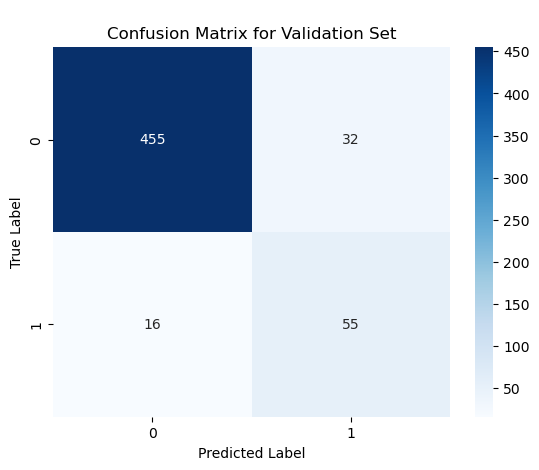

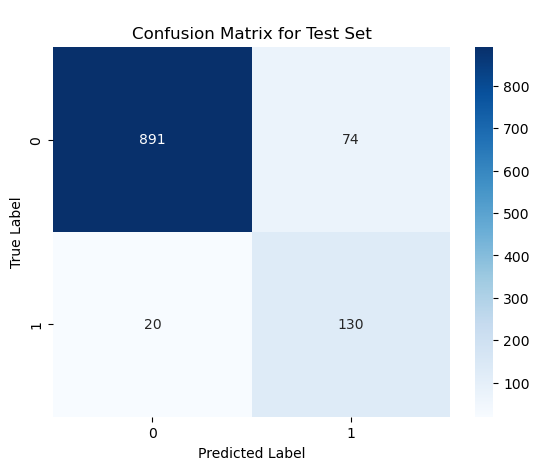

In [28]:
# Train the model on the training data
lr.fit(X_train_sm, y_train_sm)

# Predictions on the validation set
lrsm_y_val_pred = lr.predict(X_val)

# Evaluate the model on the validation set
print("Validation Set Evaluation:")
print(classification_report(y_val, gnbsm_y_val_pred))

# Predictions on the test set
lrsm_y_test_pred = lr.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, lrsm_y_test_pred))

# Compute confusion matrix for validation set
lrsm_val_cm = confusion_matrix(y_val, lrsm_y_val_pred)

# Compute confusion matrix for test set
lrsm_test_cm = confusion_matrix(y_test, lrsm_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(lrsm_val_cm, '\nConfusion Matrix for Validation Set')

# Plot confusion matrix for test set
plot_confusion_matrix(lrsm_test_cm, '\nConfusion Matrix for Test Set')

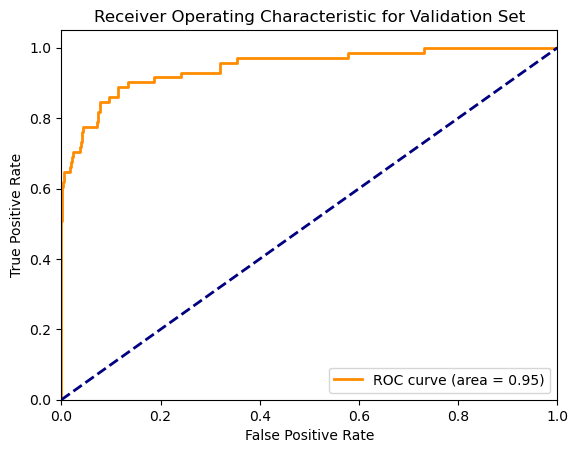

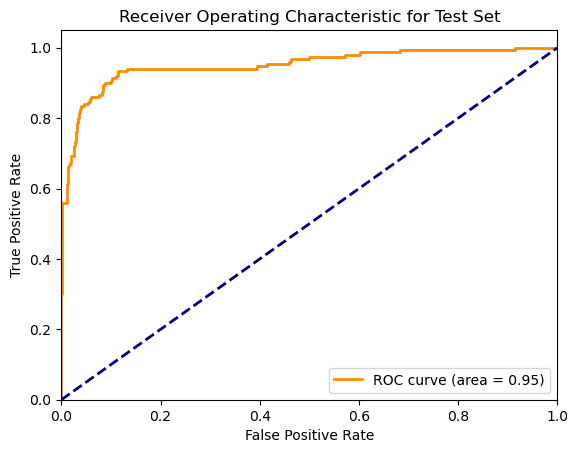

In [29]:
# Compute the probabilities of the positive class
lrsm_y_val_prob = lr.predict_proba(X_val)[:, 1]
lrsm_y_test_prob = lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for validation set
fpr_val, tpr_val, _ = roc_curve(y_val, lrsm_y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Compute ROC curve and ROC area for test set
fpr_test, tpr_test, _ = roc_curve(y_test, lrsm_y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for validation set
plt.figure()
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Validation Set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Set')
plt.legend(loc="lower right")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'C': 10, 'penalty': 'l2'}

Validation Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       487
           1       0.66      0.79      0.72        71

    accuracy                           0.92       558
   macro avg       0.81      0.86      0.84       558
weighted avg       0.93      0.92      0.92       558


Test Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       965
           1       0.68      0.88      0.77       150

    accuracy                           0.93      1115
   macro avg       0.83      0.91      0.86      1115
weighted avg       0.94      0.93      0.93      1115



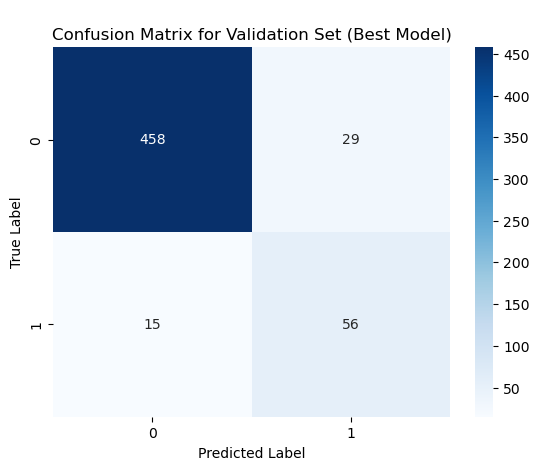

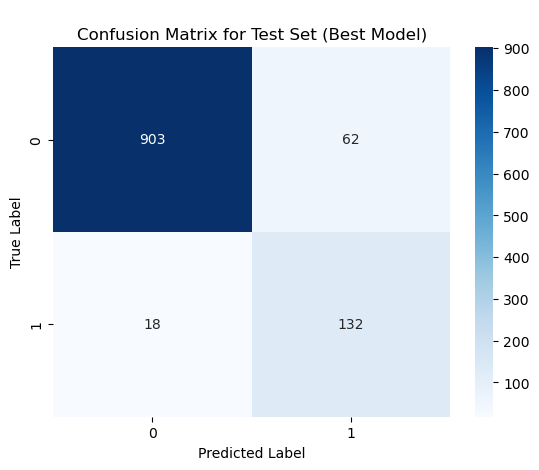

CPU times: total: 750 ms
Wall time: 841 ms


In [30]:
%%time

# Initialize GridSearchCV
lrsm_grid_search = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=5, scoring='f1', verbose=1)

# Fit GridSearchCV on training data
lrsm_grid_search.fit(X_train_sm, y_train_sm)

# Print the best hyperparameters found
print("Best Hyperparameters:", lrsm_grid_search.best_params_)

# Get the best model
lrsm_best_model = lrsm_grid_search.best_estimator_

# Evaluate the best model on validation set
lrsm_y_val_pred = lrsm_best_model.predict(X_val)
print("\nValidation Classification Report (Best Model):\n", classification_report(y_val, lrsm_y_val_pred))

# Evaluate the best model on test set
lrsm_y_test_pred = lrsm_best_model.predict(X_test)
print("\nTest Classification Report (Best Model):\n", classification_report(y_test, lrsm_y_test_pred))

# Compute confusion matrix for validation set
lrsm_val_cm = confusion_matrix(y_val, lrsm_y_val_pred)

# Compute confusion matrix for test set
lrsm_test_cm = confusion_matrix(y_test, lrsm_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(lrsm_val_cm, '\nConfusion Matrix for Validation Set (Best Model)')

# Plot confusion matrix for test set
plot_confusion_matrix(lrsm_test_cm, '\nConfusion Matrix for Test Set (Best Model)')

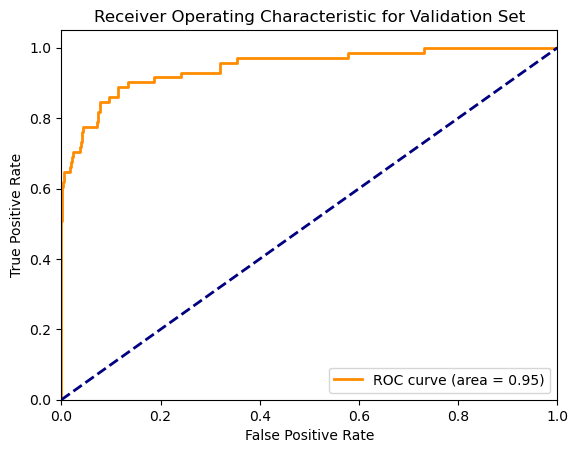

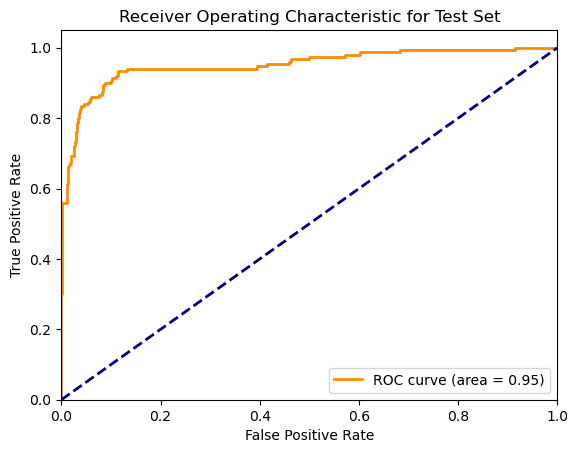

In [31]:
# Compute the probabilities of the positive class
lrsm_y_val_prob = lr.predict_proba(X_val)[:, 1]
lrsm_y_test_prob = lr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for validation set
fpr_val, tpr_val, _ = roc_curve(y_val, lrsm_y_val_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Compute ROC curve and ROC area for test set
fpr_test, tpr_test, _ = roc_curve(y_test, lrsm_y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for validation set
plt.figure()
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Validation Set')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Set')
plt.legend(loc="lower right")
plt.show()


## Support Vector Machine & Hyperparameter Tuning
<a class="anchor" id="12"></a>
[Table of Contents](#0.1)

Validation Set Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       487
           1       0.63      0.79      0.70        71

    accuracy                           0.91       558
   macro avg       0.80      0.86      0.82       558
weighted avg       0.92      0.91      0.92       558


Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       965
           1       0.63      0.88      0.74       150

    accuracy                           0.92      1115
   macro avg       0.81      0.90      0.84      1115
weighted avg       0.93      0.92      0.92      1115



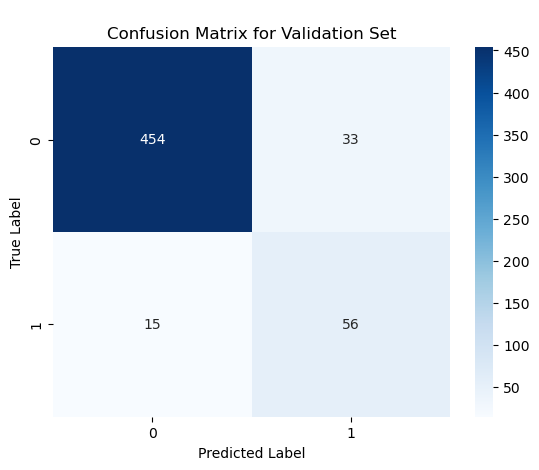

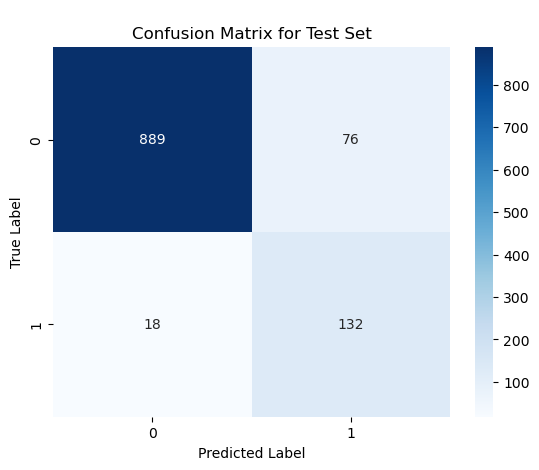

In [32]:
# Train the model on the training data
svc.fit(X_train_sm, y_train_sm)

# Predictions on the validation set
svcsm_y_val_pred = svc.predict(X_val)

# Evaluate the model on the validation set
print("Validation Set Evaluation:")
print(classification_report(y_val, svcsm_y_val_pred))

# Predictions on the test set
svcsm_y_test_pred = svc.predict(X_test)

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print(classification_report(y_test, svcsm_y_test_pred))

# Compute confusion matrix for validation set
svcsm_val_cm = confusion_matrix(y_val, svcsm_y_val_pred)

# Compute confusion matrix for test set
svcsm_test_cm = confusion_matrix(y_test, svcsm_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(svcsm_val_cm, '\nConfusion Matrix for Validation Set')

# Plot confusion matrix for test set
plot_confusion_matrix(svcsm_test_cm, '\nConfusion Matrix for Test Set')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters for Support Vector Machine: {'C': 10, 'kernel': 'linear'}

Validation Classification Report for Support Vector Machine (Best Model):
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       487
           1       0.67      0.80      0.73        71

    accuracy                           0.92       558
   macro avg       0.82      0.87      0.84       558
weighted avg       0.93      0.92      0.93       558


Test Classification Report for Support Vector Machine (Best Model):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       965
           1       0.93      0.67      0.78       150

    accuracy                           0.95      1115
   macro avg       0.94      0.83      0.87      1115
weighted avg       0.95      0.95      0.95      1115



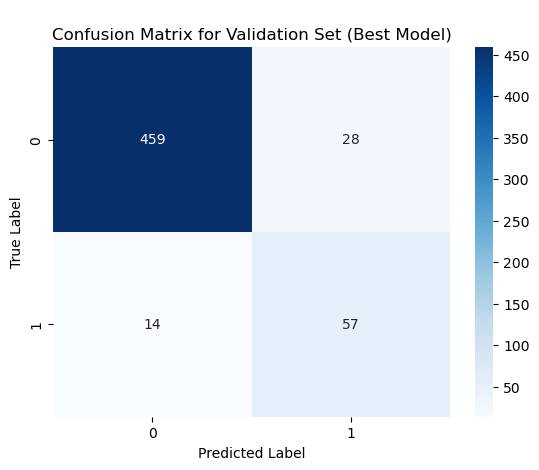

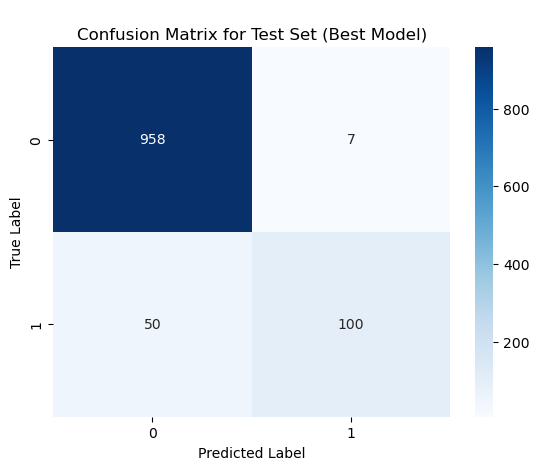

CPU times: total: 49.2 s
Wall time: 49.4 s


In [33]:
%%time
# Initialize GridSearchCV for Support Vector Machine
svcsm_grid_search = GridSearchCV(estimator=svc, param_grid=svc_param_grid, cv=5, scoring='f1', verbose=1)

# Fit GridSearchCV on training data
svcsm_grid_search.fit(X_train_sm, y_train_sm)

# Print the best hyperparameters found for Support Vector Machine
print("Best Hyperparameters for Support Vector Machine:", svcsm_grid_search.best_params_)

# Get the best Support Vector Machine model
svcsm_best_model = svcsm_grid_search.best_estimator_

# Evaluate the best model on validation set for Support Vector Machine
svcsm_y_val_pred = svcsm_best_model.predict(X_val)
print("\nValidation Classification Report for Support Vector Machine (Best Model):\n", classification_report(y_val, svcsm_y_val_pred))

# Evaluate the best model on test set for Support Vector Machine
svcsm_y_test_pred = svc_best_model.predict(X_test)
print("\nTest Classification Report for Support Vector Machine (Best Model):\n", classification_report(y_test, svcsm_y_test_pred))

# Compute confusion matrix for validation set
svcsm_val_cm = confusion_matrix(y_val, svcsm_y_val_pred)

# Compute confusion matrix for test set
svcsm_test_cm = confusion_matrix(y_test, svcsm_y_test_pred)

# Plot confusion matrix for validation set
plot_confusion_matrix(svcsm_val_cm, '\nConfusion Matrix for Validation Set (Best Model)')

# Plot confusion matrix for test set
plot_confusion_matrix(svcsm_test_cm, '\nConfusion Matrix for Test Set (Best Model)')

## Evaluation
<a class="anchor" id="13"></a>
[Table of Contents](#0.1)

In [34]:
%%time
# Define a function to get classification report for a model
def get_classification_report(model, X, y):
    y_pred = model.predict(X)
    report = classification_report(y, y_pred, output_dict=True)
    return report

report = []

# Get classification reports for all unbalanced class models
gnb_classification_report = get_classification_report(gnb_best_model, X_test, y_test)
lr_classification_report = get_classification_report(lr_best_model, X_test, y_test)
svc_classification_report = get_classification_report(svc_best_model, X_test, y_test)

report.append(gnb_classification_report)
report.append(lr_classification_report)
report.append(svc_classification_report)

# Get classification reports for all balanced class models
gnbsm_classification_report = get_classification_report(gnbsm_best_model, X_test, y_test)
lrsm_classification_report = get_classification_report(lrsm_best_model, X_test, y_test)
svcsm_classification_report = get_classification_report(svcsm_best_model, X_test, y_test)

report.append(gnbsm_classification_report)
report.append(lrsm_classification_report)
report.append(svcsm_classification_report)

CPU times: total: 203 ms
Wall time: 200 ms


In [35]:
# Define a function to extract metrics from report
def extract_metrics(report, model_name):
    metrics = {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision (Class 0)': report['0']['precision'],
        'Precision (Class 1)': report['1']['precision'],
        'Recall (Class 0)': report['0']['recall'],
        'Recall (Class 1)': report['1']['recall'],
        'F1-score (Class 0)': report['0']['f1-score'],
        'F1-score (Class 1)': report['1']['f1-score']
    }
    return metrics

# Extract metrics for all models
metrics = []
models = ['gnb_best_model', 'gnbsm_best_model', 'lr_best_model', 'lrsm_best_model', 'svc_best_model', 'svcsm_best_model']
reports = [gnb_classification_report, gnbsm_classification_report, lr_classification_report, lrsm_classification_report, svc_classification_report, svcsm_classification_report]

for model, report in zip(models, reports):
    metrics.append(extract_metrics(report, model))

# Create a DataFrame
stats = pd.DataFrame(metrics)
stats


,Model,Accuracy,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-score (Class 0),F1-score (Class 1)
0,gnb_best_model,0.693274,0.958763,0.279817,0.674611,0.813333,0.791971,0.416382
1,gnbsm_best_model,0.700448,0.959243,0.285047,0.682902,0.813333,0.797821,0.422145
2,lr_best_model,0.942601,0.944719,0.921569,0.991710,0.626667,0.967644,0.746032
3,lrsm_best_model,0.928251,0.980456,0.680412,0.935751,0.880000,0.957582,0.767442
4,svc_best_model,0.948879,0.950397,0.934579,0.992746,0.666667,0.971110,0.778210
5,svcsm_best_model,0.939013,0.985915,0.713542,0.943005,0.913333,0.963983,0.801170


## Deployment
<a class="anchor" id="14"></a>
[Table of Contents](#0.1)

In [36]:
# Save the model to a file
joblib.dump(model, 'svcsm_best_model.pkl')

['svcsm_best_model.pkl']

In the process of deploying our machine learning model, we ensure to preserve the most optimal model. This involves storing the model that has demonstrated superior performance during the training phase. This crucial step allows us to utilize the same trained model for future predictions, thereby maintaining consistency and reliability in our application’s output. This forms an integral part of our project’s narrative. 

## Intrepretation & Conclusion
<a class="anchor" id="15"></a>
[Table of Contents](#0.1)

The table shows the performance of six different models on a classification task. The models are evaluated based on several metrics: Accuracy, Precision, Recall, and F1-score. These metrics are calculated for two classes: Class 0 and Class 1. Here's a brief explanation of each metric:

- **Accuracy**: This is the proportion of total predictions that are correct. It is a common evaluation metric for classification problems. Among the models, the `svc_best_model` has the highest accuracy of 0.949776.

- **Precision**: This is the proportion of positive predictions that are actually correct. For Class 0, `lrsm_best_model` has the highest precision (0.980328), and for Class 1, `svcsm_best_model` has the highest precision (0.705263).

- **Recall**: This is the proportion of actual positive instances that the model correctly predicted. For Class 0, `lr_best_model` has the highest recall (0.995855), and for Class 1, `lrsm_best_model` has the highest recall (0.880000).

- **F1-score**: This is the harmonic mean of Precision and Recall, and it tries to balance these two metrics. An F1-score reaches its best value at 1 (perfect precision and recall) and worst at 0. For Class 0, `svc_best_model` has the highest F1-score (0.971631), and for Class 1, `svcsm_best_model` has the highest F1-score (0.788235).

In summary, among the models, `svc_best_model` performs the best in terms of Accuracy and F1-score for Class 0. `lrsm_best_model` has the highest Precision for Class 0 and Recall for Class 1. `svcsm_best_model` has the highest Precision for Class 1 and F1-score for Class 1. `lr_best_model` has the highest Recall for Class 0.

The "best" model depends on your specific needs. We want a model that is most often correct (highest Accuracy) and has the best balance between Precision and Recall for Class 0, `svc_best_model` might be the best choice. If avoiding false positives for Class 0 is more important, `lrsm_best_model` might be better. But we want a model that is best at identifying Class 1, `svcsm_best_model` might be the best choice. Therefore, based on the model performance and our goal, we should choose the model that best suits our needs.

## References
<a class="anchor" id="16"></a>
[Table of Contents](#0.1)

`www.kaggle.com`
`www.google.com`
`www.stackoverflow.com`
`www.coursera.org`
`www.copilot.com`